# __Inception Network - MXNet__

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu()

## __Getting the dataset__

In [0]:
transform = gluon.data.vision.transforms.ToTensor()

train_mnist = gluon.data.vision.CIFAR10(train = True).transform_first(transform)
test_mnist = gluon.data.vision.CIFAR10(train = False).transform_first(transform)

In [3]:
image, label = train_mnist[1]
print(image.shape)
print(label)

(3, 32, 32)
9


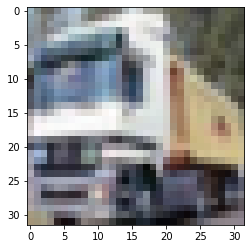

In [4]:
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.show()

## __Defining data loaders__

In [0]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = False)

## __Defining Inception Network Model Architecture__

### First we will define the inception block

In [0]:
class inceptionblock(nn.HybridBlock):
    def __init__(self, channels1, channels2, channels3, channels4):
        super(inceptionblock, self).__init__()
        self.conv1 = nn.Conv2D(channels1, kernel_size = 1, activation = 'relu')

        self.conv2 = nn.HybridSequential()
        self.conv2.add(nn.Conv2D(channels2[0], kernel_size = 1, activation = 'relu'))
        self.conv2.add(nn.Conv2D(channels2[1], kernel_size = 3, padding = 1,activation = 'relu'))
        self.conv2.add(nn.BatchNorm())

        self.conv3 = nn.HybridSequential()
        self.conv3.add(nn.Conv2D(channels3[0], kernel_size = 1, activation = 'relu'))
        self.conv3.add(nn.Conv2D(channels3[1], kernel_size = 5, padding = 2,activation = 'relu'))
        self.conv3.add(nn.BatchNorm())

        self.conv4 = nn.HybridSequential()
        self.conv4.add(nn.MaxPool2D(pool_size = 3, strides = 1, padding = 1))
        self.conv4.add(nn.Conv2D(channels4, kernel_size = 1, activation = 'relu'))
        self.conv4.add(nn.BatchNorm())

    def hybrid_forward(self, F, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(x)
        conv3 = self.conv3(x)
        conv4 = self.conv4(x)
        return F.concat(conv1, conv2, conv3, conv4, dim = 1)

### Let's visualize single block of inception network

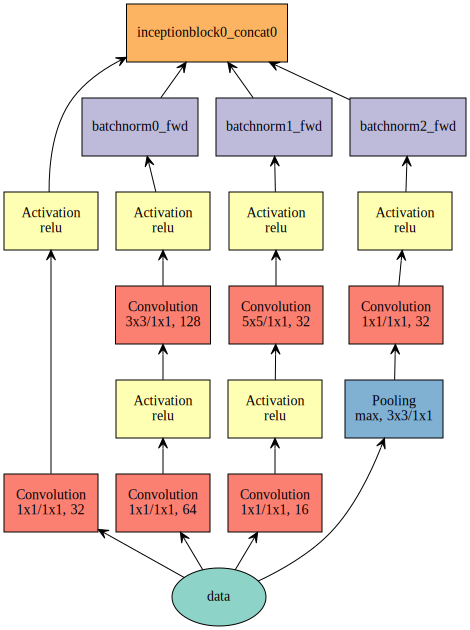

In [7]:
block = inceptionblock(32, (64, 128), (16, 32), 32)
block.initialize(ctx = ctx)
mx.viz.plot_network(block(mx.sym.var(name = 'data')), node_attrs={"fixedsize":"false"})

## __Time to build the whole model__

In [8]:
model = nn.HybridSequential()

model.add(nn.Conv2D(64, kernel_size = 7, strides = 2, padding = 3, activation = 'relu'))
model.add(nn.MaxPool2D(pool_size = 3, strides = 2, padding = 1))

model.add(nn.Conv2D(64, kernel_size = 1, activation = 'relu'))
model.add(nn.Conv2D(192, kernel_size = 3, padding = 1, activation = 'relu'))
model.add(nn.MaxPool2D(pool_size = 3, strides = 2, padding = 1))

model.add(inceptionblock(64, (96, 128), (16, 32), 32))
model.add(inceptionblock(128, (128, 192), (32, 96), 64))
model.add(nn.MaxPool2D(pool_size = 3, strides = 2, padding = 1))

model.add(inceptionblock(192, (96, 208), (16, 48), 64))
model.add(inceptionblock(160, (112, 224), (24, 64), 64))
model.add(inceptionblock(128, (128, 256), (24, 64), 64))
model.add(inceptionblock(112, (144, 288), (32, 64), 64))
model.add(inceptionblock(256, (160, 320), (32, 128), 64))
model.add(nn.MaxPool2D(pool_size = 3, strides = 2, padding = 1))

model.add(inceptionblock(256, (160, 320), (32, 128), 128))
model.add(inceptionblock(384, (192, 384), (48, 128), 128))
model.add(nn.GlobalAvgPool2D())
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): Conv2D(None -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), Activation(relu))
  (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(None -> 64, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
  (3): Conv2D(None -> 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (5): inceptionblock(
    (conv1): Conv2D(None -> 64, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
    (conv2): HybridSequential(
      (0): Conv2D(None -> 96, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
      (1): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
      (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    )
    (conv3): HybridSe

## __Summarizing the model__

In [9]:
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 3, 32, 32)               0
        Activation-1                     <Symbol conv6_relu_fwd>               0
        Activation-2                             (1, 64, 16, 16)               0
            Conv2D-3                             (1, 64, 16, 16)            9472
         MaxPool2D-4                               (1, 64, 8, 8)               0
        Activation-5                     <Symbol conv7_relu_fwd>               0
        Activation-6                               (1, 64, 8, 8)               0
            Conv2D-7                               (1, 64, 8, 8)            4160
        Activation-8                     <Symbol conv8_relu_fwd>               0
        Activation-9                              (1, 192, 8, 8)               0
           Conv2D-10        

## __Visualizing model architecture__

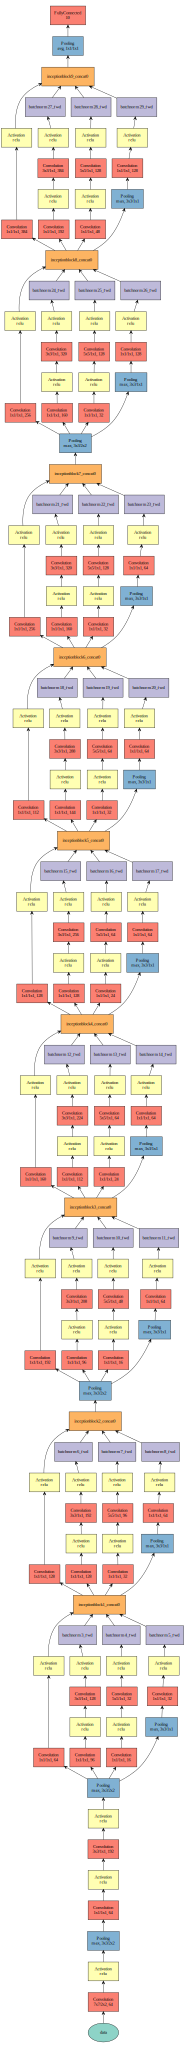

In [10]:
plot = mx.viz.plot_network(model(mx.sym.var(name = 'data')), node_attrs={"fixedsize":"false"})
plot

By hybridizing the model becomes almost 1.5x fast, as it converts dynamically defined model in to static graph. Its a really cool feature that MXNet provides

In [ ]:
model.hybridize()

## __Defining our objective loss and optimizer__

In [0]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

## __Training the model__

In [12]:
epochs = 20
batches = len(train_data)
acc = mx.metric.Accuracy()

for epoch in range(epochs):
    acc.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        acc.update(labels, outputs)
    
    print(f'Epoch: {epoch + 1} | Loss: {cum_loss.asscalar()/batches:.5f} | Training Accuracy: {acc.get()[1]:.5f}')

Epoch: 1 | Loss: 1.83370 | Training Accuracy: 0.33006
Epoch: 2 | Loss: 1.39600 | Training Accuracy: 0.49104
Epoch: 3 | Loss: 1.21781 | Training Accuracy: 0.56460
Epoch: 4 | Loss: 1.08757 | Training Accuracy: 0.61250
Epoch: 5 | Loss: 1.01173 | Training Accuracy: 0.64276
Epoch: 6 | Loss: 0.92592 | Training Accuracy: 0.67560
Epoch: 7 | Loss: 0.85912 | Training Accuracy: 0.69682
Epoch: 8 | Loss: 0.80191 | Training Accuracy: 0.72408
Epoch: 9 | Loss: 0.74436 | Training Accuracy: 0.74444
Epoch: 10 | Loss: 0.70236 | Training Accuracy: 0.75838
Epoch: 11 | Loss: 0.65505 | Training Accuracy: 0.77270
Epoch: 12 | Loss: 0.60975 | Training Accuracy: 0.79024
Epoch: 13 | Loss: 0.57003 | Training Accuracy: 0.80252
Epoch: 14 | Loss: 0.51526 | Training Accuracy: 0.82128
Epoch: 15 | Loss: 0.47354 | Training Accuracy: 0.83484
Epoch: 16 | Loss: 0.43601 | Training Accuracy: 0.84842
Epoch: 17 | Loss: 0.39993 | Training Accuracy: 0.85914
Epoch: 18 | Loss: 0.35675 | Training Accuracy: 0.87560
Epoch: 19 | Loss: 0

## __Testing the model__

In [13]:
acc.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    acc.update(labels, outputs)
acc.get()

('accuracy', 0.89852)